In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, precision_score, recall_score
import itertools
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tabulate import tabulate
import time

In [2]:
training_data=pd.read_csv(r'C:\Users\ankku\Downloads\Train_dataNIDS.csv')
training_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
testing_data = pd.read_csv(r"C:\Users\ankku\Downloads\Test_dataNIDS.csv")
testing_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [6]:
training_data.describe(include = "all")

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
count,25192.000000,25192,25192,25192,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192
unique,NaN,3,66,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,tcp,http,SF,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
freq,NaN,20526,8003,14973,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13449
mean,305.054104,NaN,NaN,NaN,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,...,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769,NaN
std,2686.555640,NaN,NaN,NaN,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,...,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333,NaN
min,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,NaN,NaN,NaN,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,0.000000,NaN,NaN,NaN,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,NaN


In [8]:
print("Training_Data: ", training_data.shape)
print("Testing Data: ", testing_data.shape)

Training_Data:  (25192, 42)
Testing Data:  (22544, 41)


In [10]:
training_data.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [12]:
training_data.duplicated().sum()

0

In [14]:
training_data['class'].value_counts()

class
normal     13449
anomaly    11743
Name: count, dtype: int64

In [15]:
def encode_labels(data):
    label_encoders = {}
    for col in data.select_dtypes(include=['object']).columns:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])
    return label_encoders

label_encoders_training = encode_labels(training_data)
label_encoders_testing = encode_labels(testing_data)

In [16]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  int32  
 2   service                      25192 non-null  int32  
 3   flag                         25192 non-null  int32  
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [17]:
training_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [19]:
training_X = training_data.drop(['class'], axis=1)
training_Y = training_data['class']

In [21]:
rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=15)
rfe.fit(training_X, training_Y)

selected_features = [col for col, support in zip(training_X.columns, rfe.get_support()) if support]
training_X = training_X[selected_features]

In [22]:
training_X

,protocol_type,service,flag,src_bytes,dst_bytes,hot,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
0,1,19,9,491,0,0,2,2,1.00,0.00,25,0.17,0.03,0.17,0.00
1,2,41,9,146,0,0,13,1,0.08,0.15,1,0.00,0.60,0.88,0.00
2,1,46,5,0,0,0,123,6,0.05,0.07,26,0.10,0.05,0.00,0.00
3,1,22,9,232,8153,0,5,5,1.00,0.00,255,1.00,0.00,0.03,0.04
4,1,22,9,199,420,0,30,32,1.00,0.00,255,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,1,16,2,0,0,0,100,7,0.07,0.07,7,0.03,0.06,0.00,0.00
25188,1,19,9,334,0,0,1,1,1.00,0.00,39,1.00,0.00,1.00,0.18
25189,1,46,1,0,0,0,105,7,0.07,0.07,13,0.05,0.07,0.00,0.00
25190,1,38,5,0,0,0,129,18,0.14,0.06,20,0.08,0.06,0.00,0.00


In [23]:
scale = StandardScaler()
training_X = scale.fit_transform(training_X)
testing_data = scale.fit_transform(testing_data)

In [25]:
print("Training_Data: ", training_X.shape)
print("Testing Data: ", testing_data.shape)

Training_Data:  (25192, 15)
Testing Data:  (22544, 41)


In [26]:
x_train, x_test, y_train, y_test = train_test_split(training_X, training_Y, train_size=0.70, random_state=1)

In [27]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(17634, 15) (7558, 15) (17634,) (7558,)


In [28]:
logistic_regression = LogisticRegression(max_iter=1200000)
logistic_regression.fit(x_train, y_train)

LogisticRegression(max_iter=1200000)

In [30]:
logistic_regression_training_score = logistic_regression.score(x_train, y_train)
logistic_regression_testing_score = logistic_regression.score(x_test, y_test)

In [31]:
print(logistic_regression_training_score, logistic_regression_testing_score)

0.9432346603153 0.9397988885948664


In [32]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [35]:
def knn_objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    return knn.score(x_test, y_test)

In [36]:
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(knn_objective, n_trials=1)
best_knn_params = study_knn.best_trial.params

In [38]:
best_n_neighbors = best_knn_params['KNN_n_neighbors']

In [40]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(x_train, y_train)
knn_training_score = knn.score(x_train, y_train)
knn_testing_score = knn.score(x_test, y_test)

In [41]:
print(knn_training_score, knn_testing_score)

0.9908132017693093 0.9890182587986239


In [45]:
svc = SVC()
svc.fit(x_train, y_train)

svc_training_score = svc.score(x_train, y_train)
svc_testing_score = svc.score(x_test, y_test)

In [46]:
print(svc_training_score, svc_testing_score)

0.9887149824203244 0.987430537179148


In [47]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)

rf_training_score = random_forest.score(x_train, y_train)
rf_testing_score = random_forest.score(x_test, y_test)

In [48]:
print(rf_training_score, rf_testing_score)

0.9999432913689463 0.9973537973008733


In [52]:
model_comparison = [
    ["KNN", knn_training_score, knn_testing_score],
    ["Logistic Regression", logistic_regression_training_score, logistic_regression_testing_score],
    ["SVC", svc_training_score, svc_testing_score],
    ["Random Forest", rf_training_score, rf_testing_score]
]

col_names = ["Model", "Training Score", "Testing Score"]
print(tabulate(model_comparison, headers=col_names))

Model                  Training Score    Testing Score
-------------------  ----------------  ---------------
KNN                          0.990813         0.989018
Logistic Regression          0.943235         0.939799
SVC                          0.988715         0.987431
Random Forest                0.999943         0.997354


In [53]:
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SupportVectorClassifier': SVC(),
    'RandomForestClassifier': RandomForestClassifier()
}

In [56]:
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

In [59]:
for name, model in models.items():
    print(f"{name} Model Validation")
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(model, x_train, y_train, cv=10, scoring=scorer)
        mean_score = round(np.mean(scores) * 100, 2)
        std_dev = round(np.std(scores) * 100, 2)
        print(f"Mean {metric_name.capitalize()}: {mean_score}% ± {std_dev}")
    print('-' * 50)

KNeighborsClassifier Model Validation
Mean Precision: 98.88% ± 0.27
Mean Recall: 98.88% ± 0.27
--------------------------------------------------
LogisticRegression Model Validation
Mean Precision: 94.31% ± 0.58
Mean Recall: 94.29% ± 0.58
--------------------------------------------------
SupportVectorClassifier Model Validation
Mean Precision: 98.57% ± 0.3
Mean Recall: 98.57% ± 0.3
--------------------------------------------------
RandomForestClassifier Model Validation
Mean Precision: 99.65% ± 0.11
Mean Recall: 99.61% ± 0.1
--------------------------------------------------


In [61]:
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': []}

for name, model in models.items():
    # Accuracy
    accuracy = model.fit(x_train, y_train).score(x_test, y_test)
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    
    for metric_name, scorer in scoring.items():
        try:
            scores = cross_val_score(model, x_train, y_train, cv=10, scoring=scorer)
            mean_score = np.mean(scores)
            if metric_name == 'precision':
                results['Precision'].append(mean_score)
            elif metric_name == 'recall':
                results['Recall'].append(mean_score)
        except Exception as e:
            print(f"Error calculating {metric_name} for {name}: {e}")


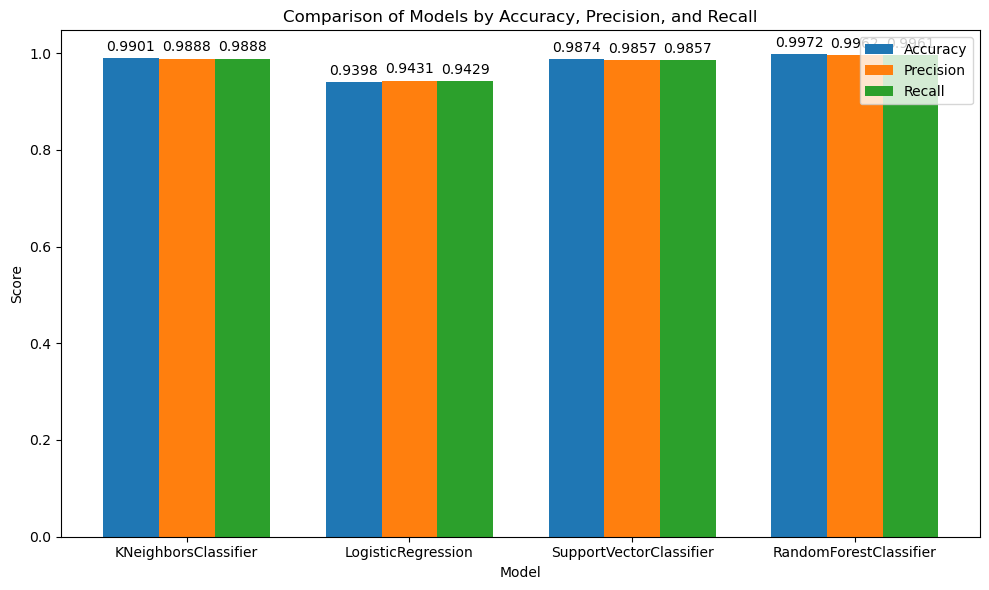

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25 
x = np.arange(len(results['Model']))

bars1 = ax.bar(x - width, results['Accuracy'], width, label='Accuracy')
bars2 = ax.bar(x, results['Precision'], width, label='Precision')
bars3 = ax.bar(x + width, results['Recall'], width, label='Recall')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparison of Models by Accuracy, Precision, and Recall')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()